In [72]:
import pickle
import numpy as np

In [73]:
#load saved training data
with open("train_qa.txt", "rb") as fp:   # Open file in binary read mode
    train_data =  pickle.load(fp) #npickle the object to restore original data

In [74]:
#load saved testing data
with open("test_qa.txt", "rb") as fp:   # Unpickling
    test_data =  pickle.load(fp)

In [75]:
#Exploring the format of the data

In [76]:
type(test_data)

list

In [77]:
type(train_data)

list

In [78]:
 #After learning, evaluate the generalization performance of the model
#example ratio : Usually 10 ~ 30%
len(test_data)

1000

In [79]:
# Data used to learn the model
#example ratio :Usually 70 ~ 90%
#Data type : valid(optional) 
#Tuning use during learning (not required)
#10 ~ 20% (optional)

len(train_data)

10000

In [80]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [81]:
' '.join(train_data[0][0]) 

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [82]:
' '.join(train_data[0][1]) 

'Is Sandra in the hallway ?'

In [83]:
train_data[0][2]

'no'

In [84]:
#setting up vocab of all words

In [85]:
# Create a set that holds the vocab words
#set' is a data type that does not allow duplicate
vocab = set()

In [86]:
all_data = test_data + train_data  # to collect words from the entire data

In [87]:
len(all_data)

11000

In [88]:
#'All_data' is a list that combines 'train_data' and 'test_data'.
#'DATA' means one '(story, question, answer).
#Data [1]' means ** Question **

vocab =set()

for story, question , answer in all_data:

    vocab = vocab.union(set(story)) #union - distint element btw anb 
    vocab = vocab.union(set(question)) 

In [89]:
#to put special tokens (words) **used in the model in advance.
#If the training data is aimed at preventing the possibility of being missing by 'yes', 'NO' **
vocab.add('no')
vocab.add('yes')

In [90]:
#vocab

In [91]:
vocab_len = len(vocab) + 1 #we add an extra space to hold a 0 for Keras's pad_sequences, 0 is a placeholder

In [92]:
vocab_len

38

In [93]:
all_story_lens = [len(data[0]) for data in all_data]

In [94]:
#all_story_lens

In [95]:
#get the longest story
max_story_len = max([len(data[0]) for data in all_data])

In [96]:
max_story_len

156

In [97]:
#get the longest question
max_question_len = max([len(data[1]) for data in all_data])

In [98]:
max_question_len

6

In [99]:
#vectorizing the Data
#Create a function that can vectorize data

In [100]:
#vocab

In [101]:
# Reserve 0 for pad_sequences
vocab_size = len(vocab) + 1

In [102]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, Permute, Dropout
from tensorflow.keras.layers import add, dot, concatenate, LSTM, Embedding


In [203]:
# integer encode sequences of words
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer = Tokenizer(filters=[]) #1.	Initializes the tokenizer without removing special characters.
tokenizer.fit_on_texts(vocab)  #2. 	Maps each word in the vocabulary to a unique integer index.

In [204]:
tokenizer.word_index

{'back': 1,
 'kitchen': 2,
 'journeyed': 3,
 'garden': 4,
 'there': 5,
 '?': 6,
 'football': 7,
 'put': 8,
 'office': 9,
 'bathroom': 10,
 'milk': 11,
 '.': 12,
 'is': 13,
 'daniel': 14,
 'moved': 15,
 'went': 16,
 'to': 17,
 'grabbed': 18,
 'hallway': 19,
 'left': 20,
 'apple': 21,
 'the': 22,
 'up': 23,
 'no': 24,
 'discarded': 25,
 'sandra': 26,
 'bedroom': 27,
 'picked': 28,
 'travelled': 29,
 'mary': 30,
 'took': 31,
 'got': 32,
 'in': 33,
 'yes': 34,
 'john': 35,
 'dropped': 36,
 'down': 37}

In [205]:
#divides the training data into three lists
train_story_text = []
train_question_text = []
train_answers = []

for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

In [360]:
#train_story_text

In [207]:
#texy_to_sequence : takes as input one or more sentences (texts) and converts each sentence into a sequence of integers


train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [208]:
len(train_story_seq)

10000

In [361]:
#train_story_seq

In [210]:
# word_index = tokenizer.word_index

In [211]:
#Functionalize Vectorization

In [362]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len, max_question_len=max_question_len):
    X = []
    Xq = []
    Y = []

    for story, query, answer in data:
        # story와 query가 문자열일 경우 단어 리스트로 변환
        if isinstance(story, str):
            story = story.split()
        if isinstance(query, str):
            query = query.split()

        print("story type:", type(story), "example element type:", type(story[0]) if len(story) > 0 else None)
        print("query type:", type(query), "example element type:", type(query[0]) if len(query) > 0 else None)

        x = [word_index[word.lower()] for word in story if word.lower() in word_index]
        xq = [word_index[word.lower()] for word in query if word.lower() in word_index]

        y = np.zeros(len(word_index) + 1)
        y[word_index[answer]] = 1

        X.append(x)
        Xq.append(xq)
        Y.append(y)

    return (pad_sequences(X, maxlen=max_story_len),
            pad_sequences(Xq, maxlen=max_question_len),
            np.array(Y))


In [363]:
#INPUTS_TRAIN: training stories converted into number sequences and padded to the maximum story length.
#queries_train:  training questions converted into number sequences and padded to the maximum question length.
#ANSWERS_TRAIN:  correct answers converted into one-hot encoded vectors.

inputs_train, queries_train, answers_train = vectorize_stories(train_data)

story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class 'str'>
story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class 'str'>
story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class 'str'>
story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class 'str'>
story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class 'str'>
story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class 'str'>
story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class 'str'>
story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class

In [364]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class 'str'>
story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class 'str'>
story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class 'str'>
story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class 'str'>
story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class 'str'>
story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class 'str'>
story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class 'str'>
story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class

In [365]:
inputs_test

array([[ 0,  0,  0, ..., 22, 27, 12],
       [ 0,  0,  0, ..., 22,  4, 12],
       [ 0,  0,  0, ..., 22,  4, 12],
       ...,
       [ 0,  0,  0, ..., 22, 21, 12],
       [ 0,  0,  0, ..., 22,  4, 12],
       [ 0,  0,  0, ..., 21,  5, 12]], dtype=int32)

In [366]:
queries_test

array([[13, 35, 33, 22,  2,  6],
       [13, 35, 33, 22,  2,  6],
       [13, 35, 33, 22,  4,  6],
       ...,
       [13, 30, 33, 22, 27,  6],
       [13, 26, 33, 22,  4,  6],
       [13, 30, 33, 22,  4,  6]], dtype=int32)

In [367]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [368]:
tokenizer.word_index['yes']

34

In [369]:
tokenizer.word_index['no']

24

In [370]:
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0., 503.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0., 497.,   0.,   0.,   0.])

In [371]:
#Build the neural network
#input encorder M
#input encorder C
#Question encorder


In [372]:
#create a model

In [373]:
from keras.models import Sequential, Model
from keras.layers import Embedding, Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [374]:
# Placeholder for inputs

In [375]:
'''
a function used to define the ** input layer ** in the Keras model.
shape of ** ** of the input data that the model will receive.
'''
#placeholder shape = (max_story_len, batchsize)
input_sequence = Input((max_story_len,)) 
question = Input((max_question_len,))

In [376]:
#Building Networks
'''
The reason we embed the story in two different ways (Encoder M and Encoder C) is to implement an attention mechanism.

In attention, the model needs to:

Compute relevance between the story and the question.

Use that relevance to focus on the important parts of the story.
'''


'\nThe reason we embed the story in two different ways (Encoder M and Encoder C) is to implement an attention mechanism.\n\nIn attention, the model needs to:\n\nCompute relevance between the story and the question.\n\nUse that relevance to focus on the important parts of the story.\n'

In [377]:
vocab_size = len(vocab) + 1

In [378]:
#Input Encorders_M

In [379]:
'''
1. Input Encoder m (#Input Encoder_M)
Convert the story into an embedding vector

Imbeding dimension: 64

Including Dropout

Output: `(Samples, Story_maxlen, Embedding_DIM)
'''

# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64)) #converted into 64-dimensional embedding vectors."
input_encoder_m.add(Dropout(0.3)) #avoid overfitting

# This encoder will output:
# (samples, story_maxlen, embedding_dim)

In [380]:
#Input Encorders_C

In [381]:
'''
2. Input Encoder c (#Input Encoder_C)
Impeding the story in another way

Embedding dimension: MAX_QUESTION_LEN (Question length)

Including Dropout

Output: `(Samples, Story_maxlen, Query_maxlen)

'''


# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_max_len)

In [382]:
#Question Encoder
''' 
Input: Question

Function: Converts the question into a sequence of 64-dimensional embedding vectors

Output Shape: (samples, query_maxlen, 64)

Purpose:
Compute match scores with the story via dot product

Help the model attend to important parts of the story based on the question

'''



' \nInput: Question\n\nFunction: Converts the question into a sequence of 64-dimensional embedding vectors\n\nOutput Shape: (samples, query_maxlen, 64)\n\nPurpose:\nCompute match scores with the story via dot product\n\nHelp the model attend to important parts of the story based on the question\n\n'

In [383]:
# embed the question into a sequence of vectors

question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64))  


question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

In [384]:
#Encode Sequences

In [385]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
#encoded---> encoder(input)
input_encoded_m = input_encoder_m(input_sequence) # → (samples, story_maxlen, 64)
input_encoded_c = input_encoder_c(input_sequence) # → (samples, story_maxlen, query_maxlen)
question_encoded = question_encoder(question)  # → (samples, query_maxlen, 64)

In [386]:
#Use dot product to compute the match between first input vector seq and the query
#compute Attention Match

In [387]:
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))  #performs a dot product between the encoded story and the encoded question.
# Resulting shape: (samples, story_len, question_len)


#activation ('softmax'): softmax function to the similarity matrix.

match = Activation('softmax')(match)


In [388]:
#Add this match matrix with the second input vector sequence
#Apply Attention to the Story Representation

In [389]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

In [390]:
#Concatenate

In [391]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [392]:
answer

<KerasTensor shape=(None, 6, 220), dtype=float32, sparse=False, ragged=False, name=keras_tensor_110>

In [393]:
# Reduce with RNN (LSTM)
#Final Answer Prediction Pipeline
answer = LSTM(32)(answer)  # (samples, 32)

In [394]:
# Regularization with Dropout
#Adds regularization to prevent overfitting by randomly disabling 50% of neurons during training.
answer = Dropout(0.5)(answer)
#Dense Layer (Output Layer) : Maps the 32-dimensional output to a vector the size of the vocabulary.
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

In [395]:
# we output a probability distribution over the vocabulary
#Converts the output to a probability distribution over the vocabulary.
answer = Activation('softmax')(answer)

# build the final model
#Builds a multi-input model with story (input_sequence) and question as inputs
model = Model([input_sequence, question], answer)


#optimizer='rmsprop': RMSprop is a good default for RNNs or sequence models.
#loss='categorical_crossentropy': appropriate since the output is a one-hot encoded vector.
#metrics=['accuracy']: to track how often the model predicts the correct word.

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [396]:
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 156)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 156, 64)   │      2,432 │ input_layer_18[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 6, 64)     │      2,432 │ input_layer_19[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_5 (Dot)         │ (None, 156, 6)    │          0 │ sequential_13[0]… │
│                     │                   │            │ sequential_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 156, 6)    │          0 │ dot_5[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 156, 6)    │        228 │ input_layer_18[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 156, 6)    │          0 │ activation_10[0]… │
│                     │                   │            │ sequential_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_4 (Permute) │ (None, 6, 156)    │          0 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 6, 220)    │          0 │ permute_4[0][0],  │
│ (Concatenate)       │                   │            │ sequential_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 32)        │     32,384 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 32)        │          0 │ lstm_4[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 38)        │      1,254 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 38)        │          0 │ dense_4[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,730 (151.29 KB)

 Trainable params: 38,730 (151.29 KB)

 Non-trainable params: 0 (0.00 B)

In [397]:
#Fit/train the nextwork
#plot out raining history
#evaluate on test set


In [398]:
# train
#a command to learn the model.
#'History': A object that stores learning results (loss, accuracy, etc.).
'''
[inputs_train, queries_train],  # 입력값: [스토리, 질문]
    answers_train,                  # 정답(정답 단어의 one-hot 인코딩)
    batch_size=32,                  # 한 번에 학습할 데이터 샘플 수
    epochs=120,                     # 전체 데이터셋을 120번 반복 학습
    validation_data=([inputs_test, queries_test], answers_test)  # 검증 데이터
)
'''
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4805 - loss: 1.1538 - val_accuracy: 0.5030 - val_loss: 0.6944
Epoch 2/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4946 - loss: 0.7099 - val_accuracy: 0.5030 - val_loss: 0.6933
Epoch 3/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5015 - loss: 0.6978 - val_accuracy: 0.5030 - val_loss: 0.6966
Epoch 4/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5015 - loss: 0.6971 - val_accuracy: 0.4970 - val_loss: 0.6986
Epoch 5/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4899 - loss: 0.6965 - val_accuracy: 0.4970 - val_loss: 0.6949
Epoch 6/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5001 - loss: 0.6954 - val_accuracy: 0.4970 - val_loss: 0.6940
Epoch 7/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4913 - loss: 0.6958 - val_accuracy: 0.4970 - val_loss: 0.6934
Epoch 8/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5002 - loss: 0.6954 - val_accu

In [401]:
filename = 'chatbot_120_epochs.h5'
model.save(filename)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


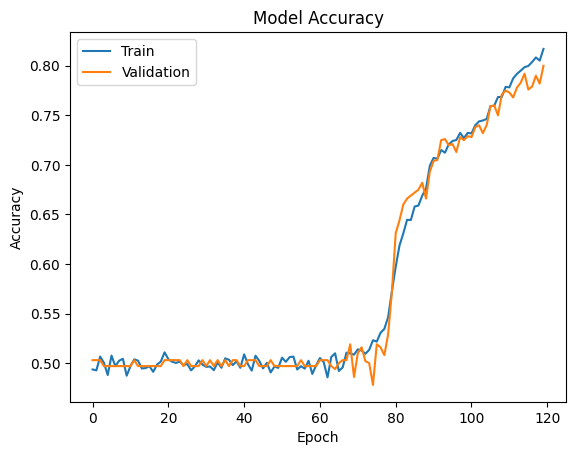

In [402]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['accuracy'])        # train accuracy
plt.plot(history.history['val_accuracy'])    # validation accuracy
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [403]:
#evaluate the test

In [404]:
'''
 1:loads the trained model weights from the saved file (filename) into the current model
 2: the loaded model to make predictions on the test data.
  -takes both as inputs and outputs predicted answers as probability distributions.
'''

model.load_weights('chatbot_120_epochs.h5')
pred_results = model.predict([inputs_test, queries_test])


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [405]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [406]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [407]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [408]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [409]:
#Generate prediction from model
#pred_results[0] — the predicted probabilities for the first test example
#np.argmax(pred_results[0]) — finds the index of the highest probability (the predicted word’s index)


val_max = np.argmax(pred_results[0])



#Loop through tokenizer.word_index to find the word (key) that matches this index (value)
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

#print("Predicted answer is: ", k)
#print("Probability of certainty was: ", pred_results[0][val_max])

In [410]:
k

'no'

In [411]:
#Writing your own stories and quetions

In [412]:
vocab #only i can use

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [413]:
# Note the whitespace of the periods, should follow the format
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [414]:
my_question = "Is the football in the garden ?"

In [415]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [416]:
mydata = [(my_story, my_question, 'yes')]

In [417]:
mydata

[('John left the kitchen . Sandra dropped the football in the garden .',
  'Is the football in the garden ?',
  'yes')]

In [418]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

story type: <class 'list'> example element type: <class 'str'>
query type: <class 'list'> example element type: <class 'str'>


In [419]:
print(type(my_story))
print(my_story)
print(type(my_question))
print(my_question)


<class 'numpy.ndarray'>
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35
  20 22  2 12 26 36 22  7 33 22  4 12]]
<class 'str'>
Is the football in the garden ?


In [420]:
pred_results = model.predict(([ my_story, my_ques]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [421]:

val_max = np.argmax(pred_results[0])


In [422]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [423]:
k

'yes'

In [425]:
print(type(story))  # 현재는 str로 나왔음
print(story)



<class 'str'>
Mary got the milk there . John moved to the bedroom .
